# Лабораторная работа 7


## Системы ОДУ (жесткий вариант)

In [1]:
import numpy as np                # импорт бибилиотеки numpy
import matplotlib.pyplot as plt   # импорт модуля matplotlib.pyplot
import scipy.integrate as integrate # импорт модуля численного интегрирования
import sympy as sym
import scipy as sp
import scipy.optimize as op
import pandas as pd
import copy
import numbers
import math
from scipy.optimize import fsolve

import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

## Полезные вещи

In [15]:
def partial(f, x, var_index, h):
    dim = len(x)
    assert var_index < dim, "Index of variable is greater than dimensity."

    vec_h = np.zeros(dim)
    vec_h[var_index] = h

    return (f(x+vec_h) - f(x-vec_h)) / (2*h)

def getJacobi(f, x, h):
    dim = len(f(x))
    assert dim == len(x), "f and x must be of same size."
    J = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):
            J[i][j] = partial(lambda x: f(x)[i], x, j, h[i])

    return J

def solveSystemNewton(f, x0, n_iter, precision, bl, tr):
    assert precision > 0, "Precision must be positive."
    dim = len(f(x0))
    assert len(x0) == dim and len(bl) == dim and len(tr) == dim, "f, x0, bl and tr must be of same size."
    h = [np.min([np.abs(x0[i] - bl[i]), np.abs(x0[i] - tr[i])]) for i in range(dim)]
    x = x0

    diff = []
    for i in range(n_iter):
        assert np.all(bl < x) and np.all(x < tr), f"Gone out of bounds on iter {i}. Diff: {diff}."
        old_x = x
        x = x - np.matmul(np.linalg.inv(getJacobi(f, x, h)), f(x))
        d = np.abs(x - old_x)
        h = d
        d_norm = np.linalg.norm(d, ord=np.inf)
        diff.append(d_norm)
        if d_norm < precision:
            break

    return x, diff

### Задача:

Решить системы ОДУ следующими классами методов:

0) Попробовать использовать для решения один из методов 3 или 4 порядка лабы 6.
1) Неявный метод Рунге-Кутта 3 порядка и выше (можно двух стадийный метод найти) 
2) Неявный метод Адамса или ФДН (методы Гира) 3 порядка и выше (внимание разгонный участок!) 
3) метод Розенброка-Ваннера 2 и 3 порядка или выше (внимание автономная или неавтономная система ОДУ!)
4) * методы Гира в представлении Нордсика 

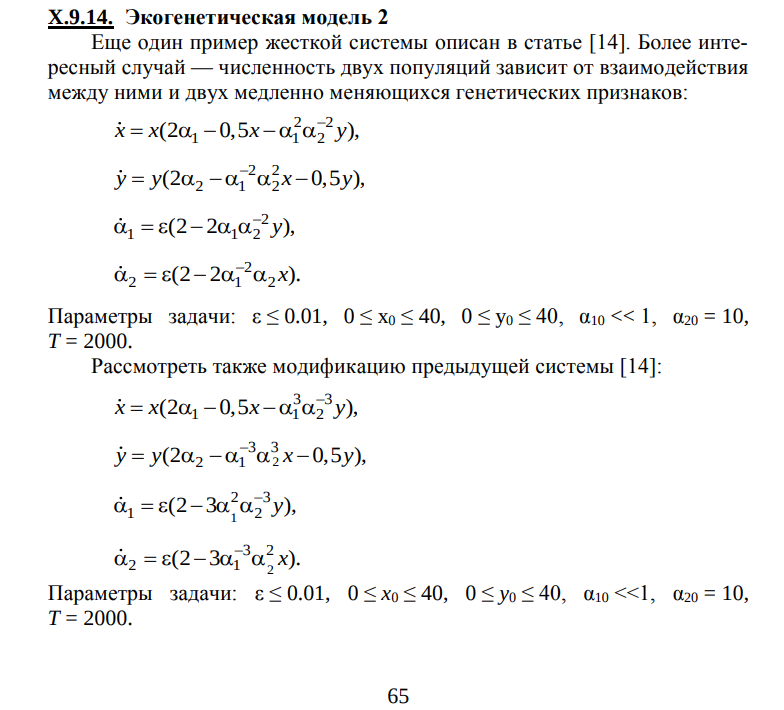

В итоге решил задачу Ван-Дер_поля
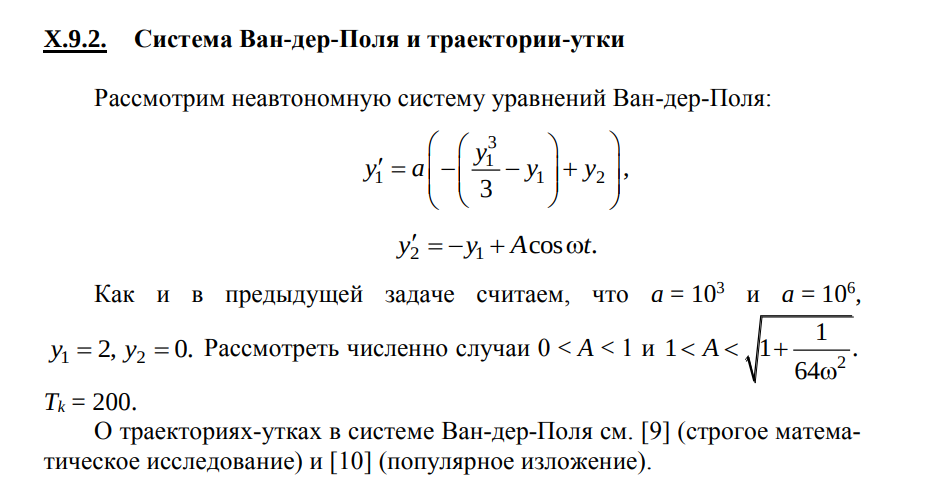

### Исходные данные:

In [3]:
# t_begin = 0
# t_end = 300
# T = 2000
# y0 = np.array([4, 10, 0.001, 10])
# def f(t, vec, e):
#     x, y, a1, a2 = vec
#     result = [
#         x * (2*a1 - 0.5*x - a1**3 * a2**(-3) * y),
#         y * (2*a2 - a1**(-3) * a2**3 * x - 0.5*y),
#         e * (2 - 2*a1**2 * a2**(-3) * y),
#         e * (2 - 2*a1**(-3) * a2**2 * x)
#     ]
    
#     return np.array(result)

init_Epsilon = 0.001

# lab6 task test
# t_begin = 0
# t_end = 100
# y0 = np.array([2, 0])
# def f(t, vec, e):
#     x, z = vec
#     result = [
#         z,
#         e * (1 - x**2) * z - x
#     ]

#     return np.array(result)

# Van Der Pol 2
init_a = 1000
init_t_begin = 0
init_t_end = 20
init_A = 0.5
init_w = 2*np.pi + 0.4
init_y0 = np.array([2, 0])
def f(t, vec, e):
    y1, y2 = vec
    result = [
        init_a * (-(y1 ** 3 / 3 - y1) + y2),
        -y1 + init_A * np.cos(init_w*t)
    ]
    return np.array(result)

In [4]:
# def drawResult(res_t, res_y, e):
#     x, y, a1, a2 = res_y.transpose()

#     fig, axes = plt.subplots(1, figsize=(10, 5))
#     axes.set_ylim(0, 1000)

#     fig.suptitle(f'Epsilon={e}')
    
#     axes.scatter(res_t, x, label='x population', s=5)
#     axes.scatter(res_t, y, label='y population', s=5)

#     # axes[1].scatter([0], [0], label='center', s=20, color='red')
#     # axes[1].scatter(x, y, label='populations', s=5)
    
#     # axes[1].legend()
#     axes.legend()

#test lab6 problem and Van Der Pole
def drawResult(res_t, res_y, e):
    x, z = res_y.transpose()

    fig, axes = plt.subplots(2, figsize=(10, 10))

    fig.suptitle(f'e={e}')
    
    axes[0].scatter(res_t, x, label='x', s=5)
    axes[0].scatter(res_t, z, label='z', s=5)

    axes[1].scatter([0], [0], label='center', s=20, color='red')
    axes[1].scatter(x, z, label='trajectory', s=5)

    xlim = axes[1].get_xlim()
    axes[1].set_xlim(xlim[0]*1.2, xlim[1]*1.2)
    
    axes[1].legend()
    axes[0].legend()

## Явный метод Рунге-Кутты

In [5]:
def classicRK4(t0, y0, h, f, n_iter=None, t_end=None, e=None):
    if n_iter is None:
        n_iter = math.ceil((t_end - t0) / h)
    if e is None:
        e = init_Epsilon

    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        k1 = f(t        , y, e)
        k2 = f(t + 1/2*h, y + 1/2*k1*h, e)
        k3 = f(t + 1/2*h, y + 1/2*k2*h, e)
        k4 = f(t +     h, y +     k3*h, e)
        y = y + h*(1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

[0.000e+00 1.000e-02 2.000e-02 ... 1.998e+01 1.999e+01 2.000e+01] [[2.00000000e+000 0.00000000e+000]
 [2.63974543e+001 1.53151065e-002]
 [2.43040399e+124 5.87262687e+038]
 ...
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]]


/tmp/ipykernel_2721475/3493670818.py:59: RuntimeWarning: overflow encountered in scalar power
  init_a * (-(y1 ** 3 / 3 - y1) + y2),
/tmp/ipykernel_2721475/3493670818.py:59: RuntimeWarning: invalid value encountered in scalar subtract
  init_a * (-(y1 ** 3 / 3 - y1) + y2),


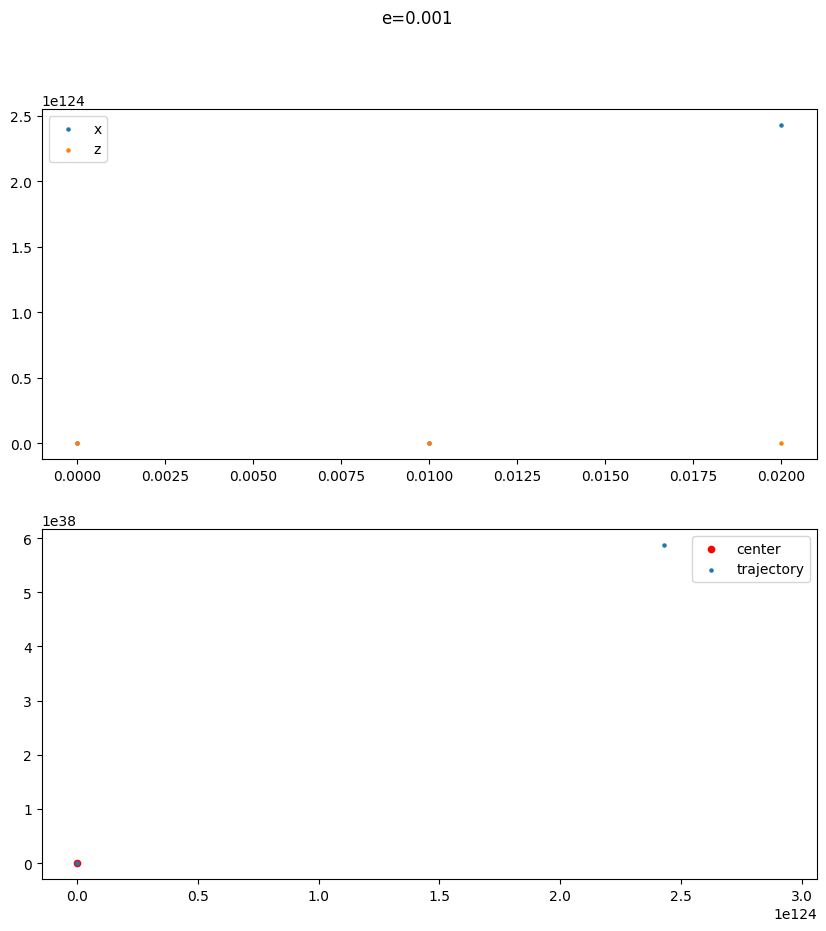

In [6]:
result_t, result_y = classicRK4(init_t_begin, init_y0, 0.01, f, t_end=init_t_end, e=init_Epsilon)
print(result_t, result_y)
drawResult(result_t, result_y, init_Epsilon)


## Неявный Рунге-Кутты

In [7]:
c = np.array([1/2 - np.sqrt(15)/10, 1/2, 1/2 + np.sqrt(15)/10])
A = np.array([
    [5/36, 2/9 - np.sqrt(15)/15, 5/36 - np.sqrt(15)/30],
    [5/36 + np.sqrt(15)/24, 2/9, 5/36 - np.sqrt(15)/24],
    [5/36 + np.sqrt(15)/30, 2/9 + np.sqrt(15)/15, 5/36]
])
b = np.array([5/18, 4/9, 5/18])

def implicitRK3(t0, y0, h, f, n_iter=None, t_end=None, e=None):
    if n_iter is None:
        n_iter = math.ceil((t_end - t0) / h)
    if e is None:
        e = Epsilon

    t = t0
    y = np.asarray(y0)
    m = y.size
    result_t = [t]
    result_y = [y.copy()]

    for _ in range(n_iter):
        def G(K_flat):
            K = K_flat.reshape((3, m))
            residuals = []
            for i in range(3):
                stage_sum = np.zeros(m)
                for j in range(3):
                    stage_sum += A[i, j] * K[j]
                fi = f(t + c[i] * h, y + h * stage_sum, e)
                residuals.append(K[i] - fi)
            return np.concatenate(residuals)

        K_flat_initial = np.tile(y, 3) 
        K_flat = op.fsolve(G, K_flat_initial)
        K = K_flat.reshape((3, m))

        y = y + h * (b @ K)
        t += h
        result_t.append(t)
        result_y.append(y.copy())

    return np.array(result_t), np.array(result_y)


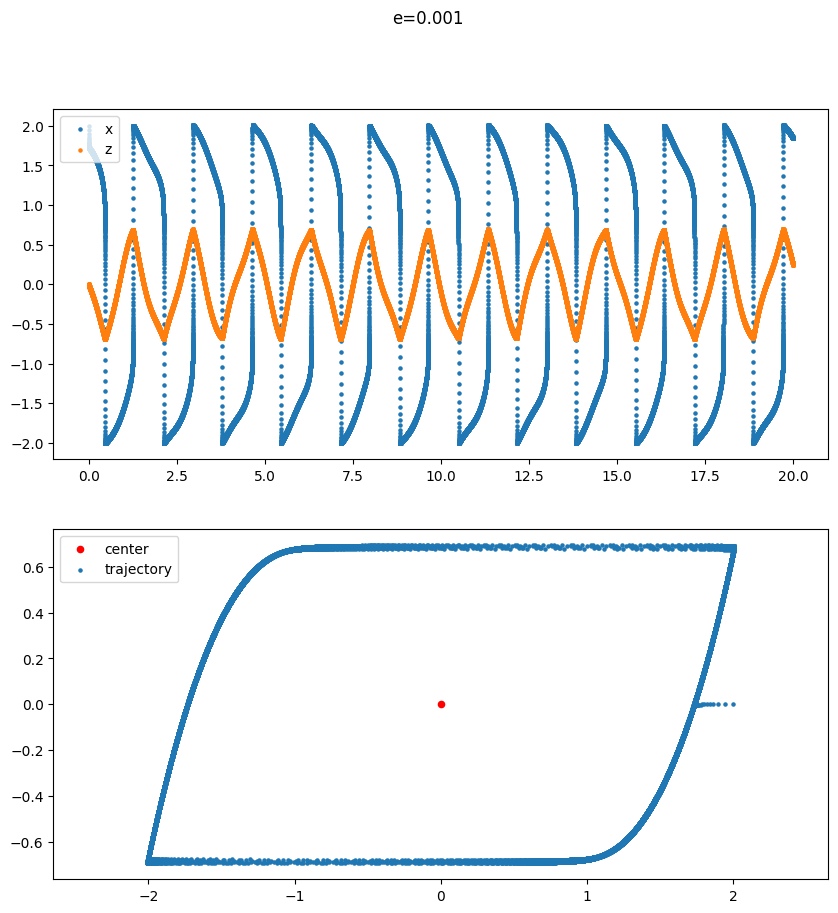

In [19]:
result_t, result_y = implicitRK3(init_t_begin, init_y0, 0.0001, f, t_end=init_t_end, e=init_Epsilon)
# print(result_t, result_y)

drawResult(result_t, result_y, init_Epsilon)


## Метод Адамса

In [9]:
def implicitAdams(t0, y0, h, f, order, n_iter=None, t_end=None):
    if n_iter is None:
        n_iter = math.ceil((t_end - t0) / h)
    if n_iter < order - 1:
        raise ValueError("n_iter must be at least order - 1")
        
    result_t, result_y = classicRK4(t0, y0, h, f, order - 1)
    result_t = list(result_t)
    result_y = list(result_y)
    
    denom = 24
    b = [9, 19, -5, 1]
    
    for i in range(order - 1, n_iter):
        t_new = result_t[-1] + h
        func = lambda Y: Y - result_y[-1] - h/denom * (
            b[0] * f(t_new, Y, init_Epsilon) +
            b[1] * f(result_t[-1], result_y[-1], init_Epsilon) +
            b[2] * f(result_t[-2], result_y[-2], init_Epsilon) +
            b[3] * f(result_t[-3], result_y[-3], init_Epsilon)
        )
        Y = fsolve(func, result_y[-1])
        result_t.append(t_new)
        result_y.append(Y)
        
    return np.array(result_t), np.array(result_y)

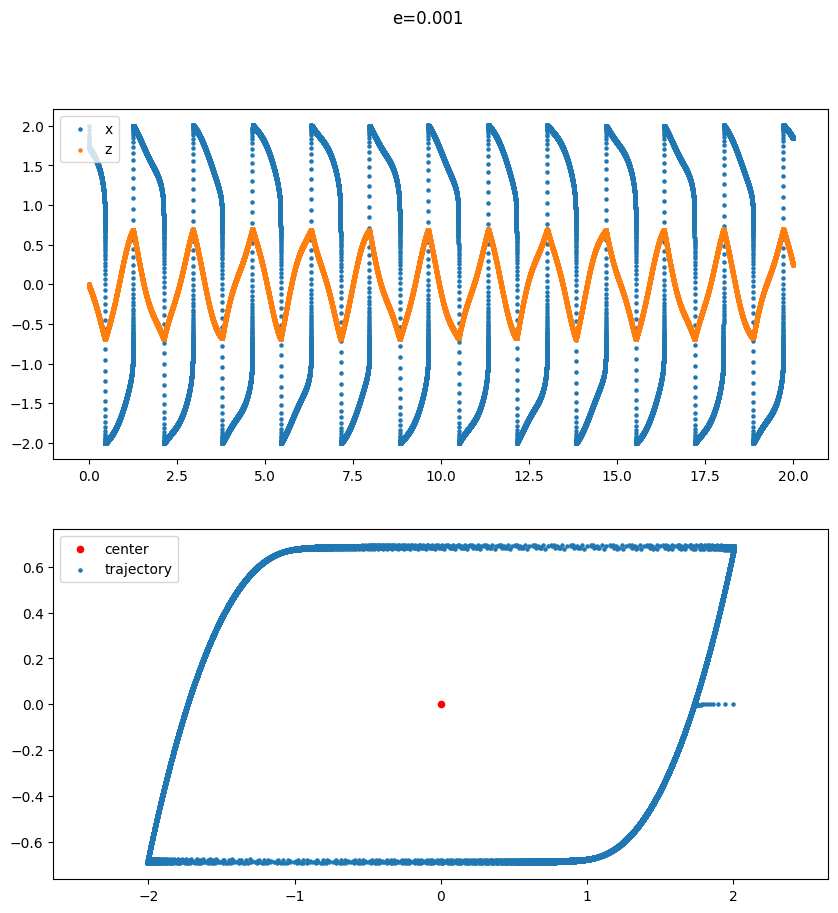

In [18]:
result_t, result_y = implicitAdams(init_t_begin, init_y0, 0.0001, f, 4, t_end=init_t_end)
# print(result_t, result_y)
drawResult(result_t, result_y, init_Epsilon)


## Метод Розенброка-Ваннера

In [16]:
def rosenbrockWanner3(t0, y0, h_step, ode_f, n_iter=None, t_end=None, e_param=None):
    if not isinstance(y0, np.ndarray):
        y0 = np.array(y0) 

    if n_iter is None:
        if t_end is None:
            raise ValueError("Either n_iter or t_end must be specified.")
        n_iter = math.ceil((t_end - t0) / h_step)
    
    result_t = np.zeros(n_iter + 1)
    result_y_shape = (n_iter + 1,) + y0.shape 
    result_y = np.zeros(result_y_shape)

    result_t[0] = t0
    result_y[0] = y0.copy()
    
    t_current = t0
    y_current = y0.copy()
    gamma = 0.5 
    I = np.eye(len(y_current)) 

    perturbation_values_for_jacobian = np.full_like(y0, 1e-8, dtype=float)
    for i in range(n_iter):
        f_for_jacobi = lambda y_arg: ode_f(t_current, y_arg, e_param)
        J = getJacobi(f_for_jacobi, y_current, perturbation_values_for_jacobian)
        
        W = I - gamma * h_step * J
        
        rhs1 = h_step * ode_f(t_current, y_current, e_param)
        K1 = np.linalg.solve(W, rhs1)
        
        y_stage2 = y_current + 0.5 * K1 
        rhs2 = h_step * ode_f(t_current + 0.5 * h_step, y_stage2, e_param) - K1 
        K2 = np.linalg.solve(W, rhs2)
        
        y_stage3 = y_current + 0.25 * K1 + 0.25 * K2 
        rhs3 = h_step * ode_f(t_current + h_step, y_stage3, e_param) - 0.5 * K2 
        K3 = np.linalg.solve(W, rhs3)
        
        y_current = y_current + (1/6 * K1 + 2/3 * K2 + 1/6 * K3) 
        t_current = t_current + h_step
        
        result_t[i+1] = t_current
        result_y[i+1] = y_current.copy()
        
    return result_t, result_y

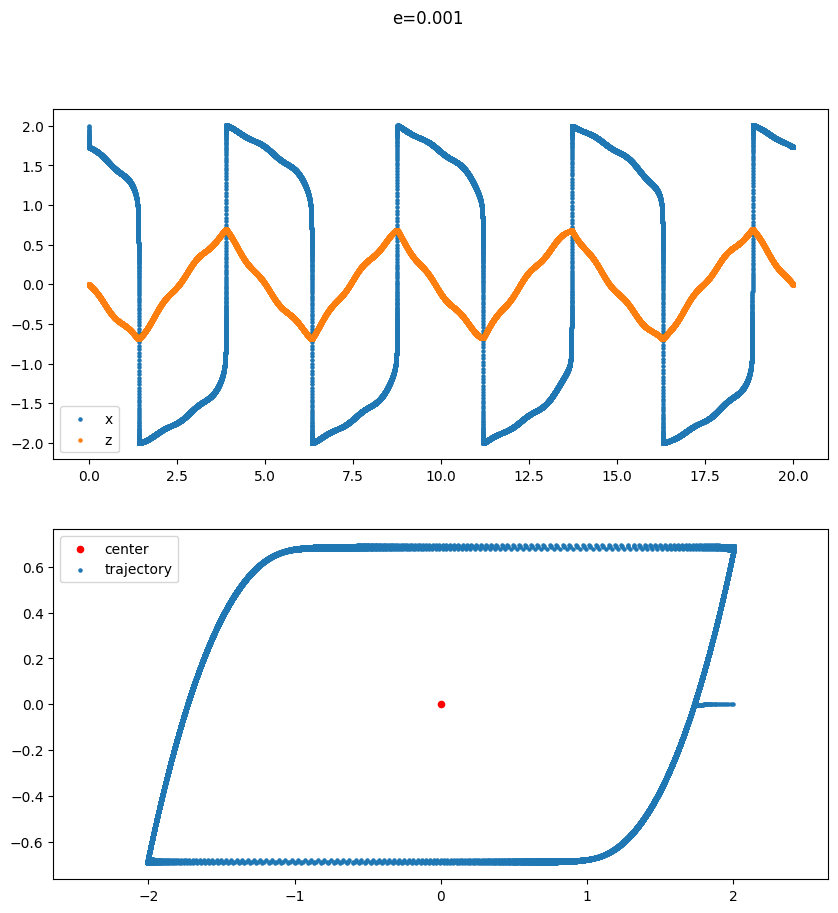

In [17]:
result_t, result_y = rosenbrockWanner3(init_t_begin, init_y0, 0.0001, f, t_end=init_t_end)
drawResult(result_t, result_y, init_Epsilon)